# Combinatoriality evolution model
## Simon Kirby

This is the Jupyter notebook for Kirby & Tamariz (2021). The code is copyright (c) 2019-2021 Simon Kirby, with contributions from Kenny Smith (developed from code for the Simulating Language course at the University of Edinburgh).

First import libraries and some functions for with normalising probabilities.

In [1]:
import random
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from math import log, exp, log2
from scipy.special import logsumexp
from functools import lru_cache

def normalize_probs(probs):
    total = sum(probs) #calculates the summed probabilities
    normedprobs = []
    for p in probs:
        normedprobs.append(p / total) 
    return normedprobs

def normalize_logprobs(logprobs):
    logtotal = logsumexp(logprobs) #calculates the summed log probabilities
    normedlogs = []
    for logp in logprobs:
        normedlogs.append(logp - logtotal) #normalise - subtracting in the log domain equivalent to divising in the normal domain
    return normedlogs

## Setting up the language model

We first have a few parameters. 

`epsilon` is the probability a signaller produces the "wrong" signal for a meaning. The learners also take this value into account when calculating the likelihood of the data they see given a particular language. In other words, signallers will understand that sometimes a speaker can generate "wrong" data and therefore won't assign a dataset with the occasional error in it zero probability. 

`gamma` is the communicative rationality parameter which controls how much signallers care about the ambiguity of the signals associated with a a target meaning in each language. (If `gamma` is zero, they don't care at all, if it is high then they will avoid producing ambiguous signals.)

`signaller_age` controls how old the signaller will be each time a pair of signaller and learner is chosen.

In [2]:
epsilon = 0.05
gamma = 0
speaker_age = 10

The language model we're using has eight possible lexical items (`ac`, `bd`, `ad`, `bc`, `pr`, `ps`, `qr`, `ps`), and four possible meanings (`0`, `1`, `2`, `3`).

In [3]:
signals = ['ac', 'bd', 'ad', 'bc', 'pr', 'ps', 'qr', 'qs']
meanings = ['0', '1', '2', '3']

Now we have need to make three lists giving details about all the possible languages.

First is a list of all the possible languages. Each language is made up for four items in a list - one for each meaning. Each item is a pair with the meaning first and the signal second.

Next is a list of *types* for each language (in the same order as the previous list). Type `0` means *degenerate*, type `1` means *holistic*, type `2` is *other* (e.g. languages that are partially degenerate), and type `3` is combinatorial.

Finally, we have the prior probability of each language based on the coding length of the grammar for that language. These are written as log probabilities.

In [4]:
languages = [[(meanings[0], s0), (meanings[1], s1), (meanings[2], s2), (meanings[3], s3)] 
             for s0 in signals for s1 in signals for s2 in signals for s3 in signals]

def type_of_language(language):
    words = [s for _, s in language]
    if len(set(words)) == 1:
        return 0
    if len(set(words)) == 4 and len(set(''.join(words))) == 4:
        return 3
    if len(set(words)) == 4:
        return 1 
    return 2

types = [type_of_language(language) for language in languages]

@lru_cache
def code_length(signals):
    code_length = 0
    for s in signals:
        code_length -= log2(signals.count(s)/len(signals))
    return code_length

def non_normed_prior(language):
    signals = ''.join([s for _, s in language])
    return 2 ** -code_length(signals)

priors = [non_normed_prior(language) for language in languages]

priors = normalize_probs(priors)

priors = [log(prior) for prior in priors]

## The learner

The three functions below do all the learning. First, the `prior` function takes a language as input and finds the right prior value from the lists above.

In [5]:
@lru_cache(maxsize=None)
def prior(language):
    for i in range(len(priors)):
        if languages[i] == language:
            return priors[i]

The `update_posterior` function does all the work really.

This function takes as input the current posterior, a meaning, and a signal. It then works out for each language what the probability of that language generating that meaning-signal pair would be. This will be $1-\epsilon$ if that meaning-signal pair is in the language and $\epsilon/3$ if that meaning-signal pair is not in the language. This is because the errors that the speaker might make are shared across all the signals, meaning that the probability of the correct data is slightly less than 1, and the probability of the wrong data is slightly greater than 0.

Because these are log probabilities, the new posterior probability for each language is just the posterior probability for that language before, plus the likelihood (normalised so everything adds up to one).

In [6]:
def update_posterior(posterior, meaning, signal):
    in_language = log(1 - epsilon)
    out_of_language = log(epsilon / (len(signals) - 1))
    new_posterior = []
    for i in range(len(posterior)):
        if (meaning, signal) in languages[i]:
            new_posterior.append(posterior[i] + in_language)
        else:
            new_posterior.append(posterior[i] + out_of_language)
    return normalize_logprobs(new_posterior)

Finally, we have a function to return a specific language from the posterior by the usual probabilistic sampling process.

In [7]:
def sample(posterior):
    return languages[log_roulette_wheel(posterior)]

## Signalling and iterated learning

The next chunk of code handles the actual iterated learning simulation.

First, we have a function for signalling, which takes a meaning and a language and posterior and returns a signal. The way this works is for the signaller to go through every possible signal and then adds up the posterior probabilities of all the languages where that signal is associated with the correct meaning, weighted by the ambiguity of the signal. The more ambiguous a signal is in a particular language (i.e. the number of possible meanings in that language it is associated with) the more the posterior probability is downweighted. The communicative rationality parameter `gamma` controls how much this downweighting happens. With `gamma` equal to zero, then no downweighting occurs, and all that matters is that the signal is associated with the correct meaning.

The actual signal returned is the signal that maximises the sum of the weighted posterior probabilities.

In [8]:
def signalling(posterior, meaning):
    signal_probs = []
    for signal in signals:
        probs = []
        for i in range(len(posterior)):
            language = languages[i]
            if (meaning, signal) in language:
                competitors = [s for _, s in language].count(signal)
                probs.append(log((1 / competitors) ** gamma) + posterior[i])
        signal_probs.append(logsumexp(probs))
    max_signal_prob = max(signal_probs)
    signal_index = random.choice([i for i, v in enumerate(signal_probs) if v == max_signal_prob])
    return signals[signal_index]

The next two functions handle the population. `new_population` creates a population of newborn agents, each with their posterior over grammars equal to the prior. 

`population_communication` has a pair of agents in the population communicate with each other. The signaller is chosen according to the `signaller_age` parameter, and the learner is chosen at random from the whole population. A meaning is chosen completely at random. The signaller produces a signal, and the learner updates their posterior. 

In [9]:
def new_population(popsize):
    population = []
    for i in range(popsize):
        population.append(list(priors))
    return population    

def population_communication(population):
    learner_index = random.randrange(len(population))
    signaller_index = signaller_age - 1
    meaning = random.choice(meanings)
    signal = signalling(population[signaller_index], meaning)
    if random.random() < epsilon:
        other_signals = [s for s in signals if s != signal]
        signal = random.choice(other_signals)
    population[learner_index] = update_posterior(population[learner_index], meaning, signal)

Now, we have the actual simulation function, and a wee supporting function that gives some summary statistics about the overall posterior probability for *degenerate*, *holistic*, *other*, and *combinatorial* languages. This is purely to make visualising the results easier!

The `simulation` function takes as input a number of generations to run the simulation, the number of rounds of interaction there will be each generation, the number of rounds of initial tranining there will be on the seed language, the population size, and the seed languages that the very first generation is going to learn.

Note that each generation, we measure the posterior distribution of the oldest learner (for the graphs), remove them, and add a new learner.

In [10]:
def language_stats(posteriors):
    stats = [0., 0., 0., 0.] # degenerate, holistic, other, combinatorial
    for p in posteriors:
        for i in range(len(p)):
            stats[types[i]] += exp(p[i]) / len(posteriors)
    return stats

def simulation(generations, rounds, initial_training, popsize, seed_languages):
    results = []
    population = new_population(popsize)
    for i in range(popsize):
        seed_language = random.choice(seed_languages)
        for j in range(initial_training): # This just trains the initial population on the seed language
            meaning, signal = random.choice(seed_language)
            population[i] = update_posterior(population[i], meaning, signal)
    results.append(language_stats(population))

    for i in range(generations):
        for j in range(rounds):
            population_communication(population)
        results.append(language_stats([population[-1]])) # We measure the stats just on the oldest learner
        population = new_population(1) + population[:-1] # remove the oldest and add a newborn learner
                       
    return results

## Running the simulation

We've got a handy function to plot the results of a bunch of simulation runs, which will show us the average posterior probability assigned to *degenerate*, *holistic*, and *combinatorial* languages on one graph. 

In [11]:
def plot_time_graph(results, title):

    average_degenerate = []
    average_holistic = []
    average_combinatorial = []

    for i in range(len(results[0])):
        total_degenerate = 0
        total_holistic = 0
        total_combinatorial = 0
        for result in results:
            total_degenerate += result[i][0]
            total_holistic += result[i][1]
            total_combinatorial += result[i][3]
        average_degenerate.append(total_degenerate / len(results))
        average_holistic.append(total_holistic / len(results))
        average_combinatorial.append(total_combinatorial / len(results))

    plt.plot(average_degenerate, color='orange', label='degenerate')
    plt.plot(average_holistic, color='green', label='holistic')
    plt.plot(average_combinatorial, color='purple', label='combinatorial')
    plt.xlabel('time')
    plt.ylabel('proportion')
    plt.title(title)
    plt.legend()
    plt.grid()
    

### Rapid emergence of combinatoriality

With commuicatively rational agents learning from relatively young signallers.

In [12]:
initial = [('0', 'pr'), ('1', 'qs'), ('2', 'ad'), ('3', 'bc')] # initial holistic language
gamma = 100            # communicatively rational
signaller_age = 6      # learning from relatively young agents
res1 = []
for i in range(100): 
    print('.', end='') 
    # generations, rounds, initial_training, popsize, seed
    res1.append(simulation(200, 20, 20, 10, [initial]))  # Only a relatively short number of generations needed

....................................................................................................

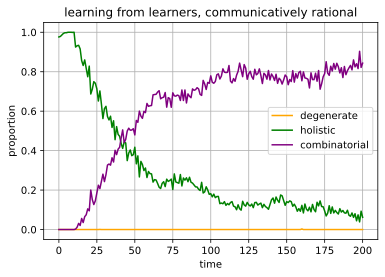

In [13]:
plot_time_graph(res1, "learning from learners, communicatively rational")
plt.savefig("g1.pdf")

### Slow emergence of combinatoriality

When agents learn from the more experienced signallers, combinatoriality emerges but extremely slowly. Languages stay holistic for a long time.

In [14]:
initial = [('0', 'pr'), ('1', 'qs'), ('2', 'ad'), ('3', 'bc')]
gamma = 100        # Communicatively rational
signaller_age = 10 # Learning only from the most experienced agent
res2 = []
for i in range(100):
    print('.', end='')
    # generations, rounds, initial_training, popsize, data
    res2.append(simulation(2000, 20, 50, 10, [initial])) 
    

....................................................................................................

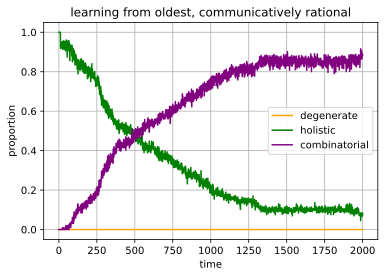

In [15]:
plot_time_graph(res2, "learning from oldest, communicatively rational")
plt.savefig("g2.pdf")

### Emergence of degenerate languages

Without communicative rationality, degenerate languages emerge. These are simple, but inexpressive.

In [16]:
initial = [('0', 'pr'), ('1', 'qs'), ('2', 'ad'), ('3', 'bc')]
gamma = 0          # No communicative rationality
signaller_age = 10 # Learning from only the most experienced agent
res3 = []
for i in range(100):
    print('.', end='')
    # generations, rounds, initial_training, popsize, data
    res3.append(simulation(2000, 20, 50, 10, [initial]))

....................................................................................................

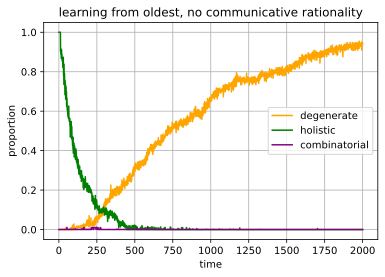

In [17]:
plot_time_graph(res3, "learning from oldest, no communicative rationality")
plt.savefig("g3.pdf")

### Combinatorial homesign

If homesign is actually combinatorial, this seems to suggest these simulations are unnecessary, since languages will all start out already structured. However, we argue that non-combinatorial languages will emerge out of the interaction between indivdiuals with distinct homesigning systems, and only later will shared combinatoriality emerge. We can test this by rerunning the learning from learners simulation where the first set of individuals are all using distinct combinatorial systems.

In [20]:
homesigns = [l for l in languages if type_of_language(l) == 3] # all the possible combinatorial languages
gamma = 100            # communicatively rational
signaller_age = 6      # learning from relatively young agents
res4 = []
for i in range(100): 
    print('.', end='') 
    # generations, rounds, initial_training, popsize, seed
    res4.append(simulation(200, 20, 20, 10, homesigns)) # Each individual will be initialised 
                                                        # with a random homesign system

................................................................................................

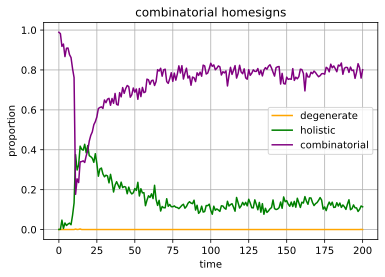

In [21]:
plot_time_graph(res4, "combinatorial homesigns")
plt.savefig("g4.pdf")

In [25]:
import pickle
pickle.dump( [res1, res2, res3, res4], open( "cultural_evolution_and_design_features_results.p", "wb" ) )